# Opinion modeling using ETM

In [ ]:
# !pip install pytorch-lightning &> /dev/null
!pip install -U ray &> /dev/null
!pip install tensorboardX &> /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import spacy
import torchtext
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.data.utils import get_tokenizer

import ray
from ray import tune

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


/usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [ ]:
!ls "drive/Shareddrives/AV_Twitter_Project/Topic Modeling"
!ls drive/Shareddrives/CSCE636DeepLearning/Homework/glove

 archive   doc		  figures    opinion_modeling   temp
 data	  'Fatal Crash'   notebook   src
glove.6B.100d.txt  glove.6B.200d.txt  glove.6B.300d.txt  glove.6B.50d.txt


In [ ]:
root_dir = "drive/Shareddrives/AV_Twitter_Project/Topic Modeling"
data_path = os.path.join(
    root_dir, 
    "data/Link_Events_10_day/mallet_8000/all_events_8000")
glove_path = "drive/Shareddrives/CSCE636DeepLearning/Homework/glove/"

In [ ]:
df = pd.read_csv(os.path.join(data_path, "doc_topic.csv"), index_col=0)
print(df.columns)
df = df[["tweet_id", "clean_tokens", "author", "receiver", "date", "depth", "parent_id"]]
df.columns = ["tweet_id", "tokens", "author", "receiver", "date", "depth", "parent_id"]
df.head()

Index(['tweet_id', 'text', 'author', 'receiver', 'date', 'depth', 'parent_id',
       'tokens', 'clean_tokens', 'num_tokens', 'event_name', 'event_id',
       'event_date', 'event_type', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic'],
      dtype='object')


,tweet_id,tokens,author,receiver,date,depth,parent_id
0,516530375066415104,idea water pump toyota,queenoluwa,nigeriaautopart,2014-09-29 06:10:12,0,51651301580262604
1,516550713892409344,need shock absorber honda civic model rear,uncu_gee,nigeriaautopart,2014-09-29 07:31:01,0,51651301580262604
2,516556692239421440,roof parking facility solution making public road,zoontjensuk,parkingreview,2014-09-29 07:54:47,0,51655073631098470
3,516584840616243200,brand new toks,uncu_gee,nigeriaautopart,2014-09-29 09:46:38,0,51651301580262604
4,516589730356408320,idea transfer vehicle,kei_kei_twi,mujinbot,2014-09-29 10:06:04,0,51658925281392640


## Build torchtext data pipeline

In [ ]:
tokenizer = get_tokenizer("basic_english")
counter = Counter()
for line in df["tokens"]:
    counter.update(tokenizer(line))

max_vocab_size = 10000
vocab = Vocab(counter, max_size=max_vocab_size, min_freq=3)

print(f"unique tokens in vocab: {len(vocab)}")

unique tokens in vocab: 9052


In [ ]:
# preprocess pipeline
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

## Build dataset

In [ ]:
class AvDataset(Dataset):
    def __init__(self, df_text):
        super().__init__()
        self.df_text = df_text

    def __len__(self):
        return self.df_text.shape[0]

    def __getitem__(self, idx):
        text = self.df_text["tokens"].iloc[idx]
        processed_text = torch.Tensor(text_pipeline(text)).long()
        return processed_text.to(device)

def pad_collate(batch):
    """ pad sequence with zeros """
    x_lens = [len(x) for x in batch]
    xx_pad = pad_sequence(batch, batch_first=True, padding_value=0)
    return xx_pad

def prepare_data(df, split_ratio, batch_size):
    dataset = AvDataset(df)

    # train test split
    num_total = len(dataset)
    num_test = np.ceil(num_total * split_ratio).astype(int)
    num_valid = ((num_total - num_test) * split_ratio).astype(int)
    num_train = (num_total - num_test - num_valid).astype(int)
    
    print("Prepare data")
    print(f"train: {num_train}, valid: {num_valid}, test: {num_test}")

    train_set, valid_set, test_set = random_split(
        dataset, [num_train, num_valid, num_test])

    # create loaders 
    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, collate_fn=pad_collate
    )
    valid_loader = DataLoader(
        valid_set, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
    )
    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
    )
    return train_loader, valid_loader, test_loader

## Build lightning dataset

In [ ]:
class LitAvDataset(pl.LightningDataModule):
    def __init__(self, dataset, batch_size=128):
        self.batch_size = batch_size
        self.dataset = dataset

    def setup(self):
        # train test split
        num_total = len(self.dataset)
        num_test = np.ceil(num_total * 0.2).astype(int)
        num_valid = ((num_total - num_test) * 0.2).astype(int)
        num_train = (num_total - num_test - num_valid).astype(int)
        
        print("Prepare dataset")
        print(f"train: {num_train}, valid: {num_valid}, test: {num_test}")

        self.train_set, self.valid_set, self.test_set = random_split(
            av_dataset, [num_train, num_valid, num_test])
    
    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, 
                          shuffle=True, collate_fn=pad_collate)
        
    def val_dataloader(self):
        return DataLoader(self.valid_set, batch_size=self.batch_size, 
                          shuffle=False, collate_fn=pad_collate)
        
    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, 
                          shuffle=True, collate_fn=pad_collate)

## Load Glove embeddings
maybe should train our own embedding

In [ ]:
embedding_dim = 200
embeddings_index = {}
f = open(os.path.join(glove_path, f'glove.6B.{embedding_dim}d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# 2 more spots for <unk> and <pad>
embedding_matrix = np.zeros((max_vocab_size + 2, embedding_dim))
for word, i in vocab.stoi.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_vocab_size:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

print(f"embedding matrix shape: {embedding_matrix.shape}")
print(f"active embedding: {sum(embedding_matrix.sum(1) > 0)}")

embedding matrix shape: (10002, 200)
active embedding: 6962


## Build models

In [ ]:
def make_bow(docs, vocab_size):
    batch_size = docs.shape[0]
    bow = torch.zeros(batch_size, vocab_size).to(device)
    for i in range(batch_size):
        bow[i, docs[i].long()] = 1
    return bow

In [ ]:
class Encoder(nn.Module):
    """ variational distribution for topic inference """
    def __init__(
        self, 
        num_topics, 
        vocab_size,
        embedding_dim, 
        hidden_dim, 
        dropout=0.5
        ):
        super().__init__()
        self.num_topics = num_topics
        self.vocab_size = vocab_size

        self.fc1 = nn.Linear(vocab_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.head = nn.Linear(hidden_dim, num_topics * 2)
        self.dropout = nn.Dropout(p=dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        """ 
        the origional implementation used 
        bow input rather than embedding 
        """
        x = make_bow(x, self.vocab_size)

        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.head(x)

        mu = x[:, :self.num_topics]
        logvar = x[:, self.num_topics:]
        return mu, logvar

    def sample(self, mu, logvar):
        """ return topic prob logits """
        eps = torch.randn(mu.shape).to(device)
        z = mu + eps * torch.exp(0.5 * logvar)
        return z

class Decoder(nn.Module):
    """ generative distribution of documents """
    def __init__(
        self, 
        num_topics, 
        vocab_size,
        embedding_dim, 
        embedding_matrix=None,
        train_embedding=False
        ):
        super().__init__()
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        
        self.topic_embedding = nn.Linear(
            embedding_dim, num_topics, bias=False
        )

        if embedding_matrix is not None:
            self.word_embedding = torch.from_numpy(
                    embedding_matrix
            ).to(torch.float32).to(device)
        else:
            self.word_embedding = torch.randn(
                vocab_size, embedding_dim
            ).to(torch.float32).to(device)

        self.word_embedding.requires_grad = train_embedding

    def forward(self, z):
        # variational doc-topic probs
        topic_probs = torch.softmax(z, dim=1)
        
        # get topic-term probs
        topic_term = torch.softmax(
            self.topic_embedding(self.word_embedding), dim=0)
        
        # generative doc-word probs
        doc_word_logits = topic_probs.matmul(topic_term.t())
        doc_word = torch.log(doc_word_logits + 1e-10)
        return doc_word

In [ ]:
class ETM(nn.Module):
    """ Embedded topic model """
    def __init__(self, config):
        super().__init__()
        # model config
        self.num_topics = config["num_topics"]
        self.vocab_size = config["vocab_size"]
        self.embedding_dim = config["embedding_dim"]
        self.hidden_dim = config["hidden_dim"]
        self.dropout = config["dropout"]
        self.embedding_matrix = config["embedding_matrix"]
        self.train_embedding = config["train_embedding"]
        
        # init models
        self.encoder = Encoder(
            self.num_topics, 
            self.vocab_size, 
            self.embedding_dim, 
            self.hidden_dim, 
            self.dropout
        )
        self.decoder = Decoder(
            self.num_topics, 
            self.vocab_size, 
            self.embedding_dim, 
            self.embedding_matrix,
            self.train_embedding
        )

    def forward(self, docs):
        """ 
        args:
            docs : doc-term sparse matrix 

        returns:
            elbo : average negative ELBO of documents
        """
        # get variational doc-topic probs
        mu, logvar = self.encoder(docs)
        topic_logits = self.encoder.sample(mu, logvar)
        
        # get generative doc-word probs
        doc_word = self.decoder(topic_logits)
        
        # get expected document probs
        bow = make_bow(docs, self.vocab_size)
        log_probs = torch.sum(bow * doc_word, dim=1)

        # get loss
        elbo = self.ELBO(log_probs, mu, logvar)
        return elbo

    def normal_kl(self, mu, logvar):
        kl = 0.5 * torch.sum(logvar.exp() + mu.pow(2) - 1.0 - logvar, dim=1)
        return kl

    def ELBO(self, log_probs, mu, logvar):
        elbo = torch.mean(log_probs - self.normal_kl(mu, logvar))
        return -elbo

## Build visualization functions

In [ ]:
# viasualize topic term
def get_topic_term(decoder, vocab, topk=20):
    decoder.eval()
    num_topics = decoder.num_topics

    # get topic and vocab embedding
    fake_vocab = torch.ones(
        decoder.vocab_size).unsqueeze(1).to(torch.float32)
    vocab_embedding = fake_vocab * decoder.word_embedding.data.cpu()
    topic_embedding = decoder.topic_embedding.weight.data.unsqueeze(1).cpu()
    
    # get topic-term
    topic_term = torch.softmax(
        torch.sum(vocab_embedding * topic_embedding, -1), dim=1)
    
    # get top k words per topic 
    top_word_index = torch.topk(topic_term, topk, dim=1, largest=False)[1]
    topic_term_dict = {
        f"topic_{i}": [vocab.itos[top_word_index[i, j]] for j in range(topk)] 
        for i in range(num_topics)
    }
    return topic_term_dict

# metrics
def get_topic_coherence(loader, topic_term, vocab):
    topic_term = list(topic_term.values())
    topic_term_index = torch.Tensor([
        [vocab.stoi[term] for term in topic] for topic in topic_term
    ]).long()

    (num_topics, num_terms) = topic_term_index.shape
    
    # get full doc-term matrix
    doc_term = [torch.empty(0)] * len(loader)
    for i, data_batch in enumerate(loader):
        doc_term[i] = make_bow(data_batch, len(vocab)).cpu()

    doc_term = torch.cat(doc_term[:i+1], dim=0)
    num_docs = doc_term.shape[0]
    
    # word occurrance prob
    p_i = doc_term.sum(0) / num_docs
    
    # calculate mutual info
    TC = torch.zeros(num_topics)
    for i in range(num_terms):
        for j in range(i+1, num_terms):
            p_ij = torch.sum(
                (doc_term[:, topic_term_index[:, i]] + \
                doc_term[:, topic_term_index[:, j]]) > 0, 
            dim=0) / num_docs

            num = torch.log(p_ij + 1e-10) - \
                torch.log(p_i[topic_term_index[:, i]] + 1e-10) - \
                torch.log(p_i[topic_term_index[:, j]] + 1e-10)
            dnm = -torch.log(p_ij + 1e-10)
            TC += num / dnm
    
    return TC.mean()

def get_topic_diversity(topic_term):
    """ number of unique words in topics """
    word_list = []
    count = 0
    for topic in topic_term.keys():
        for word in topic_term[topic]:
            word_list.append(word)
            count += 1
    word_list = list(set(word_list))
    TD = len(word_list) / count
    return TD

## Build training functions

In [ ]:
def train_epoch(model, train_loader, optimizer, debug=False):
    model.train()
    optimizer.zero_grad()
    
    train_elbo = 0
    for i, data_batch in enumerate(train_loader):
        elbo = model(data_batch)
        elbo.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_elbo += elbo

        if debug and i > 1:
            break

    return train_elbo / (i+1)

def evaluate(model, eval_loader, debug=False):
    model.eval()

    eval_elbo = 0
    with torch.no_grad():
        for i, data_batch in enumerate(eval_loader):
            elbo = model(data_batch)
            eval_elbo += elbo

            if debug and i > 1:
                break
            
    return eval_elbo / (i + 1)

def train(config, checkpoint_dir=None):
    debug = config["debug"]
    if debug:
        pprint.pprint(config)
    
    etm = ETM(config)
    etm.to(device)
    optimizer = torch.optim.Adam(etm.parameters(), lr=config["lr"])
    
    print("init models")

    train_loader, valid_loader, test_loader = prepare_data(
        config["data"], config["split_ratio"], config["batch_size"])
    
    start_time = time.time()
    history = {"train_elbo": [], "valid_elbo": []}
    for e in range(config["epochs"]):
        train_elbo = train_epoch(etm, train_loader, optimizer, debug)
        valid_elbo = evaluate(etm, valid_loader, debug)
        
        # tune checkpoint
        # with tune.checkpoint_dir(step=e) as checkpoint_dir:
        #     path = os.path.join(checkpoint_dir, "checkpoint")
        #     torch.save(
        #         (etm.state_dict(), optimizer.state_dict()), path
        #     )
        # tune.report(loss=valid_elbo)
        
        history["train_elbo"].append(train_elbo.item())
        history["valid_elbo"].append(valid_elbo.item())
        
        if (e + 1) % config["verbose"] == 0:
            print("epoch: {0}, train_elbo: {1:.3f}, valid_elbo: {2:.3f}, t: {3:.3f}".\
                format(e+1, train_elbo, valid_elbo, time.time() - start_time)
            )

        # visualize topics
        if (e + 1) % config["vis_interval"] == 0:
            topic_term = get_topic_term(
                etm.decoder, config["vocab"], config["topk"]
            )
            TC = get_topic_coherence(valid_loader, topic_term, config["vocab"])
            TD = get_topic_diversity(topic_term)
            
            print("\n" + "*"*50)
            for key in topic_term.keys():
                print(f"{key}: {topic_term[key]}")
            print("*"*50)
            print(f"TC: {TC:.3f}, TD: {TD:.3f}\n")

    print("training complete")
    return history

In [ ]:
config = {
    # model config
    "num_topics": 10,
    "vocab_size": len(vocab),
    "embedding_dim": 200,
    "hidden_dim": 512,
    "dropout": 0.5,
    "embedding_matrix": None,
    "train_embedding": True,
    # data config
    "data": df,
    "split_ratio": 0.2,
    "batch_size": 300,
    # training config
    "lr": 0.001,
    "epochs": 350,
    "verbose": 5,
    # vis config
    "vocab": vocab,
    "topk": 20,
    "vis_interval": 10,
    # debug config
    "debug": False,
}

history = train(config)

init models
Prepare data
train: 23780, valid: 5945, test: 7432
epoch: 5, train_elbo: 75.036, valid_elbo: 74.811, t: 24.558
epoch: 10, train_elbo: 73.824, valid_elbo: 73.851, t: 48.871

**************************************************
topic_0: ['nox', 'wish', 'avenue', 'murderous', 'enter', 'art', 'slaughter', 'anticipation', 'grain', 'date', 'beat', 'tornado', 'column', 'inadequate', 'bingo', 'track', 'lightweight', 'rongai', 'okay', 'baked']
topic_1: ['story', 'aircraft', 'ordinary', 'halting', 'airborne', 'rumor', 'litigation', 'passenger', 'illuminated', 'overvalued', 'prevented', 'promotion', 'cool', 'impunity', 'engadget', 'firm', 'hyundai', 'fey', 'culture', 'mahindra']
topic_2: ['awan', 'appearance', 'dod', 'taxed', 'skateboard', 'endanger', 'grill', 'occurs', 'ave', 'pupil', 'home', 'rollover', 'ripping', 'independent', 'poverty', 'chassis', 'muskrat', 'belief', 'dip', 'rubbish']
topic_3: ['philippine', 'urbanism', 'placement', 'respond', 'posed', 'seating', 'guidance', 'turo

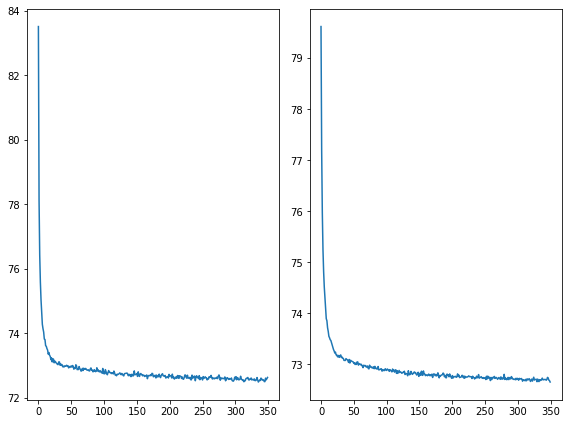

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].plot(history["train_elbo"], label="train_elbo")
ax[1].plot(history["valid_elbo"], label="valid_elbo")
plt.tight_layout()
plt.show()

In [ ]:
# result = tune.run(
#     partial(train, df),
#     resources_per_trial={"gpu": 1},
#     config=config
# )

drive  sample_data


## Smoke test

In [ ]:
num_topics = 10
vocab_size = max_vocab_size + 2
hidden_dim = 64
dropout = 0.5
train_embedding = True
lr = 1e-3

encoder = Encoder(
    num_topics, vocab_size, embedding_dim, 
    hidden_dim, dropout, embedding_matrix
).to(device)

decoder = Decoder(
    num_topics, vocab_size, 
    embedding_dim, embedding_matrix, train_embedding
).to(device)

etm = ETM(
    num_topics, vocab_size, embedding_dim, 
    hidden_dim, dropout, embedding_matrix
).to(device)

print(etm)

ETM(
  (encoder): Encoder(
    (fc1): Linear(in_features=10002, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (head): Linear(in_features=64, out_features=20, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (topic_embedding): Linear(in_features=200, out_features=10, bias=False)
  )
)


In [ ]:
with torch.no_grad():
    data_batch = next(iter(train_loader))
    
    mu, logvar = encoder(data_batch)
    z = encoder.sample(mu, logvar)
    
    doc_word = decoder(z)

    # elbo = etm(data_batch)
    # print(f"ELBO: {elbo}")

In [ ]:
topic_term = get_topic_term(etm.decoder, vocab, 20)
TC = get_topic_coherence(valid_loader, topic_term, vocab)
TD = get_topic_diversity(topic_term)

for key in topic_term.keys():
    print(f"{key}: {topic_term[key]}")

print(f"TC: {TC}, TD: {TD}")

topic_0: ['resolution', 'missiles', 'baseless', 'weapons', 'proposals', 'suggestions', 'concrete', 'missile', 'detailed', 'placards', 'measures', 'firing', 'inspectors', 'thorough', 'nuclear', 'penalties', 'inspections', 'refute', 'carefully', 'conclusions']
topic_1: ['disney', 'entertainment', 'mfr', 'executive', 'mansion', 'movie', 'hotels', 'theater', 'hotel', 'hollywood', 'secretive', 'corporate', 'enron', 'disneyland', 'chief', 'movies', 'house', 'cbs', 'wb', 'executives']
topic_2: ['yards', 'writes', 'nytimes', 'editor', 'pages', 'mail', 'summary', 'information', 'contributed', 'news', 'writer', 'wk', 'acres', 'email', 'photos', 'airports', 'articles', 'nyt', 'journal', 'column']
topic_3: ['iphones', 'neural', 'compression', 'regenerative', 'benders', 'dementia', 'pe', 'fisker', 'musk', 'cough', 'cognitive', 'smartphones', 'exponentially', 'floppy', 'ghz', 'cord', 'addiction', 'nirvana', 'needles', 'bluetooth']
topic_4: ['warranty', 'filed', 'partial', 'settlement', 'median', 'to

## Build trainer

In [ ]:
class Trainer():
    def __init__(self, config):
        self.model = ETM(
            num_topics=config["num_topics"],
            vocab_size=config["vocab_size"],
            embedding_dim=config["embedding_dim"],
            hidden_dim=config["hidden_dim"],
            dropout=config["dropout"],
            embedding_matrix=config["embedding_matrix"]
        ).to(device)
        
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), config["lr"]
        )
        
        self.vocab = config["vocab"]
        self.topk = config["topk"]
        self.verbose = config["verbose"]
        self.vis_interval = config["vis_interval"]
        self.debug = config["debug"]

    def train_epoch(self, train_loader):
        self.model.train()
        self.optimizer.zero_grad()
        
        train_elbo = 0
        for i, data_batch in enumerate(train_loader):
            elbo = self.model(data_batch)
            elbo.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            train_elbo += elbo

            if self.debug and i > 1:
                break

        return train_elbo / (i+1)

    def evaluate(self, eval_loader):
        self.model.eval()

        eval_elbo = 0
        with torch.no_grad():
            for i, data_batch in enumerate(eval_loader):
                elbo = self.model(data_batch)
                eval_elbo += elbo

                if self.debug and i > 1:
                    break
                
        return eval_elbo / (i + 1)
    
    def train(self, loaders, epochs):
        (train_loader, valid_loader) = loaders
        
        start_time = time.time()
        history = {"train_elbo": [], "valid_elbo": []}
        for e in range(epochs):
            train_elbo = self.train_epoch(train_loader)
            valid_elbo = self.evaluate(valid_loader)
            
            history["train_elbo"].append(train_elbo)
            history["valid_elbo"].append(valid_elbo)
            
            if (e + 1) % self.verbose == 0:
                print("epoch: {0}, train_elbo: {1:.3f}, valid_elbo: {2:.3f}, t: {3:.3f}".\
                      format(e+1, 
                             train_elbo, 
                             valid_elbo, 
                             time.time() - start_time)
                )

            # visualize topics
            if (e + 1) % self.vis_interval == 0:
                topic_term = get_topic_term(
                    self.model.decoder, self.vocab, self.topk
                )
                TC = get_topic_coherence(valid_loader, topic_term, self.vocab)
                TD = get_topic_diversity(topic_term)
                
                print("\n" + "*"*50)
                for key in topic_term.keys():
                    print(f"{key}: {topic_term[key]}")
                print("*"*50)
                print(f"TC: {TC:.3f}, TD: {TD:.3f}\n")

        return history

In [ ]:
config = {
    # model config
    "num_topics": 20,
    "vocab_size": max_vocab_size + 2,
    "embedding_dim": embedding_dim,
    "hidden_dim": 128,
    "dropout": 0.5,
    "embedding_matrix": embedding_matrix,
    "lr": 1e-3,
    # visualization config
    "vocab": vocab,
    "topk": 20,
    "verbose": 5,
    "vis_interval": 10,
    # other config
    "debug": False,
}

trainer = Trainer(config)

In [ ]:
train_epochs = 200
history = trainer.train([train_loader, valid_loader], train_epochs)

epoch: 5, train_elbo: 152.298, valid_elbo: 151.292, t: 19.519
epoch: 10, train_elbo: 148.839, valid_elbo: 148.192, t: 39.068

**************************************************
topic_0: ['rideshare', 'bertel', 'tbf', 'huangs', 'tncs', 'solarcity', 'lvl', 'rtcs', 'welp', 'intels', 'wks', 'dbl', 'usatoday', 'assholes', 'qs', 'woah', 'bikeshare', 'sua', 'kornhauser', 'fca']
topic_1: ['bidu', 'kornhauser', 'rideshare', 'macan', 'woah', 'plz', 'isolo', 'bikeshare', 'muthaiga', 'gopro', 'lvl', 'wks', 'aswell', 'urmson', 'bertel', 'welp', 'solarcity', 'prob', 'huangs', 'attenuator']
topic_2: ['lvl', 'plz', 'muthaiga', 'bidu', 'comms', 'axios', 'rideshare', 'huangs', 'wks', 'heres', 'flamin', 'bruh', 'jaywalker', 'macan', 'aeb', 'gett', 'bikeshare', 'goog', 'usatoday', 'turo']
topic_3: ['wud', 'plz', 'woah', 'bruh', 'bidu', 'gett', 'prob', 'goog', 'imma', 'krafcik', 'minicabs', 'ohh', 'cont', 'truely', 'rideshare', 'habe', 'usatoday', 'macan', 'heres', 'ummm']
topic_4: ['bidu', 'kornhauser', '

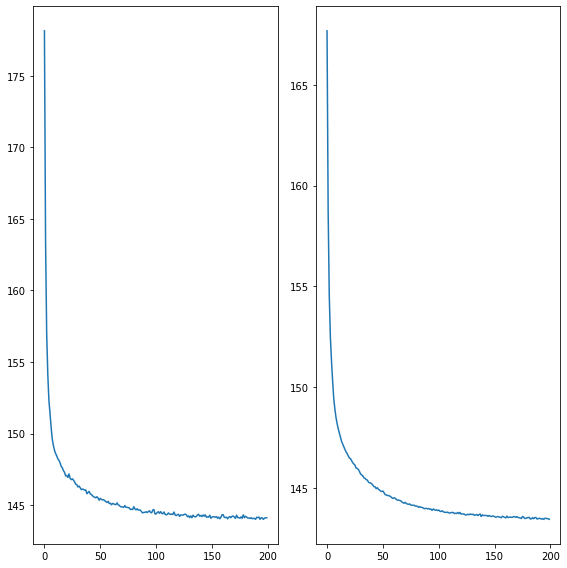

In [ ]:
# plot history
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].plot(history["train_elbo"], label="train elbo")
ax[1].plot(history["valid_elbo"], label="valid elbo")
plt.tight_layout()
plt.show()